# Collisional Ionization Equilibrium of H and He

Example of using `pism` to solve for collisional ionization equilibrium (CIE) for a hydrogen-helium mixture and plot the ionization states as a function of temperature.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import sympy as sp
from time import time

# Simple processes
A simple process is defined by a single reaction, with a specified rate.

Let's inspect the structure of a single process, the gas-phase recombination of H+: `H+ + e- -> H + hν` 

In [3]:
from pism.processes import CollisionalIonization, GasPhaseRecombination

process = GasPhaseRecombination("H+")
print(f"Name: {process.name}")
print(f"Heating rate coefficient: {process.heat_rate_coefficient}")
print(f"Heating rate per cm^-3: {process.heat}"),
print(f"Rate coefficient: {process.rate_coefficient}")
print(f"Recombination rate per cm^-3: {process.rate}")
#print(f"RHS of e- number density equation: {process.network["e-"]}")

Name: Gas-phase recombination of H+
Heating rate coefficient: -1.46719838641439e-26*sqrt(T)/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Heating rate per cm^-3: -1.46719838641439e-26*sqrt(T)*n_H+*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Rate coefficient: 1.41621465870114e-10/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Recombination rate per cm^-3: 1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)


Note that all symbolic representations assume CGS units as is standard in ISM physics.

## Composing processes
Now let's define our full network as a sum of simple processes

In [4]:
processes = [CollisionalIonization(s) for s in ("H", "He", "He+")] + [GasPhaseRecombination(i) for i in ("H+", "He+", "He++")]
#processes = [CollisionalIonization(s) for s in ("H",)] + [GasPhaseRecombination(i) for i in ("H+",)]

system = sum(processes)

Summed processes keep track of all subprocesses, e.g. the total net heating rate is:

In [5]:
system.heat

-1.5e-10*n_He+*n_e-/T**0.3647 + 1.2746917300104e-21*sqrt(T)*n_H*n_e-*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 1.46719838641439e-26*sqrt(T)*n_H+*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252) + 9.37661057635428e-22*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 4.9524176975855e-22*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 5.86879354565754e-26*sqrt(T)*n_He++*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)

Summing processes also sums all chemical and gas/dust cooling/heating rates. 

In [6]:
system.print_network_equations()

dn_e-/dt = 5.85e-11*sqrt(T)*n_H*n_e-*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 2.38e-11*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 5.68e-12*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1) - n_He+*n_e-*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.93241606228058e-10/(sqrt(T)*(0.000164934781188511*sqrt(T) + 1.0)**1.7892*(4.84160744811772*sqrt(T) + 1.0)**0.2108)) - 1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252) - 5.66485863480458e-10*n_He++*n_e-/(sqrt(T)*(0.00059608348423851*sqrt(T) + 1.0)**1.748*(0.281807561832489*sqrt(T) + 1.0)**0.252)
dn_H+/dt = n_e-*(5.85e-8*T*n_H*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252 - 1.41621465870114e-10*n_H+*(sqrt(10)*sqrt(T) + 1000)*exp(157809.1/T))*exp(-157809.1/T)/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252*(sqrt(10)*sqrt(T) + 1000))
d

## Solving ionization equilibrium

Today we would like to solve for ionization equilibrium given a temperature `T`. That means finding the chemical abundances that set this thing to 0:

In [7]:
system.network["e-"]

5.85e-11*sqrt(T)*n_H*n_e-*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 2.38e-11*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 5.68e-12*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1) - n_He+*n_e-*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.93241606228058e-10/(sqrt(T)*(0.000164934781188511*sqrt(T) + 1.0)**1.7892*(4.84160744811772*sqrt(T) + 1.0)**0.2108)) - 1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252) - 5.66485863480458e-10*n_He++*n_e-/(sqrt(T)*(0.00059608348423851*sqrt(T) + 1.0)**1.748*(0.281807561832489*sqrt(T) + 1.0)**0.252)

The full network above had 6 equations, but we may introduce two known quantities: the total H number density and the helium mass fraction Y.

`n_Htot = n_H + n_H+`

`n_He + n_He+ + n_He++ = Y/(4-Y) n_Htot`

We may also invoke conservation of electrons:

`n_e- = n_H+ + n_He+ + 2 n_He++`

This allows us to eliminate 3 variables from the system.

In [8]:
Y = sp.symbols("Y")
nHtot = sp.symbols("n_Htot")

substitutions = {
                "n_e-": sp.symbols("n_H+") + sp.symbols("n_He+")  + sp.symbols("n_He++"),
                "n_H+": nHtot - sp.symbols("n_H"),
                 "n_He++": Y/(4-4*Y) * nHtot - sp.symbols("n_He") - sp.symbols("n_He+"),                  
}

for species in system.network:
    for s in substitutions:
        system.network[species] = system.network[species].subs(s, substitutions[s])

system.network

defaultdict(int,
            {'e-': 5.85e-11*sqrt(T)*n_H*(Y*n_Htot/(4 - 4*Y) - n_H - n_He + n_Htot)*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 2.38e-11*sqrt(T)*n_He*(Y*n_Htot/(4 - 4*Y) - n_H - n_He + n_Htot)*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 5.68e-12*sqrt(T)*n_He+*(Y*n_Htot/(4 - 4*Y) - n_H - n_He + n_Htot)*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1) - n_He+*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.93241606228058e-10/(sqrt(T)*(0.000164934781188511*sqrt(T) + 1.0)**1.7892*(4.84160744811772*sqrt(T) + 1.0)**0.2108))*(Y*n_Htot/(4 - 4*Y) - n_H - n_He + n_Htot) - 5.66485863480458e-10*(Y*n_Htot/(4 - 4*Y) - n_He - n_He+)*(Y*n_Htot/(4 - 4*Y) - n_H - n_He + n_Htot)/(sqrt(T)*(0.00059608348423851*sqrt(T) + 1.0)**1.748*(0.281807561832489*sqrt(T) + 1.0)**0.252) - 1.41621465870114e-10*(-n_H + n_Htot)*(Y*n_Htot/(4 - 4*Y) - n_H - n_He + n_Htot)/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252),
             'H+': 5.85e-11*sq

### Symbolic Jacobian
For our remaining unknowns we can define a Jacbon w.r.t. those quantities:

In [9]:
unknowns = sp.symbols("n_H n_He n_He+")
#unknowns = sp.symbols("n_H n_e-")
knowns = sp.symbols("T n_Htot Y")

jac = []
reduced_network = []
for species, rhs in system.network.items(): 
    if f"n_{species}" in substitutions: continue
    reduced_network.append(rhs)
    jac.append([sp.diff(rhs, u) for u in unknowns])

sp.Matrix(jac)

Matrix([
[                                                                                                                                                                                                                              2.38e-11*sqrt(T)*n_He*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) - n_He+*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.93241606228058e-10/(sqrt(T)*(0.000164934781188511*sqrt(T) + 1.0)**1.7892*(4.84160744811772*sqrt(T) + 1.0)**0.2108)),                                                                                                                                                                                                                                                                                                                                                                                               2.38e-11*sqrt(T)*n_He*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 2.38e-11*sqrt(T)*(Y*n_Htot/(4 - 4*Y) - n_H - n_He + n_Htot)*exp

## Numerical solution

To solve the system numerically we may use Newton iterations:

$$ \mathbf{X}_{n+1} = \mathbf{X}_{\rm n} - \mathbf{J}^{-1}\left(\mathbf{X}_{\rm n}\right) \mathbf{f(\mathbf{X}_{\rm n})}$$

where $\mathbf{X}$ is the vector of unknowns, $\mathbf{f}(\mathbf{X})$ is the vector of RHS in the chemical rates we wish to solve = 0, and $J$ is the Jacobian of $f(X)$.

13.680745363235474 [array([1.00000000e+00, 7.89473684e-02, 2.84746375e-62]), array([1.00000000e+00, 7.89473684e-02, 6.82051252e-90]), array([1.00000000e+000, 7.89473684e-002, 1.63387182e-117]), array([1.00000000e+000, 7.89473684e-002, 1.11111527e-120]), array([1.00000000e+000, 7.89473684e-002, 7.67943237e-120]), array([1.00000000e+000, 7.89473684e-002, 5.23763736e-119]), array([1.00000000e+000, 7.89473684e-002, 3.52547588e-118]), array([1.00000000e+000, 7.89473684e-002, 2.34215442e-117]), array([1.00000000e+000, 7.89473684e-002, 1.53591763e-116]), array([1.00000000e+000, 7.89473684e-002, 9.94291777e-116]), array([1.00000000e+000, 7.89473684e-002, 6.35465415e-115]), array([1.00000000e+000, 7.89473684e-002, 4.00996428e-114]), array([1.00000000e+000, 7.89473684e-002, 2.49860556e-113]), array([1.00000000e+000, 7.89473684e-002, 1.53745123e-112]), array([1.00000000e+000, 7.89473684e-002, 9.34305743e-112]), array([1.00000000e+000, 7.89473684e-002, 5.60787120e-111]), array([1.00000000e+000, 7.

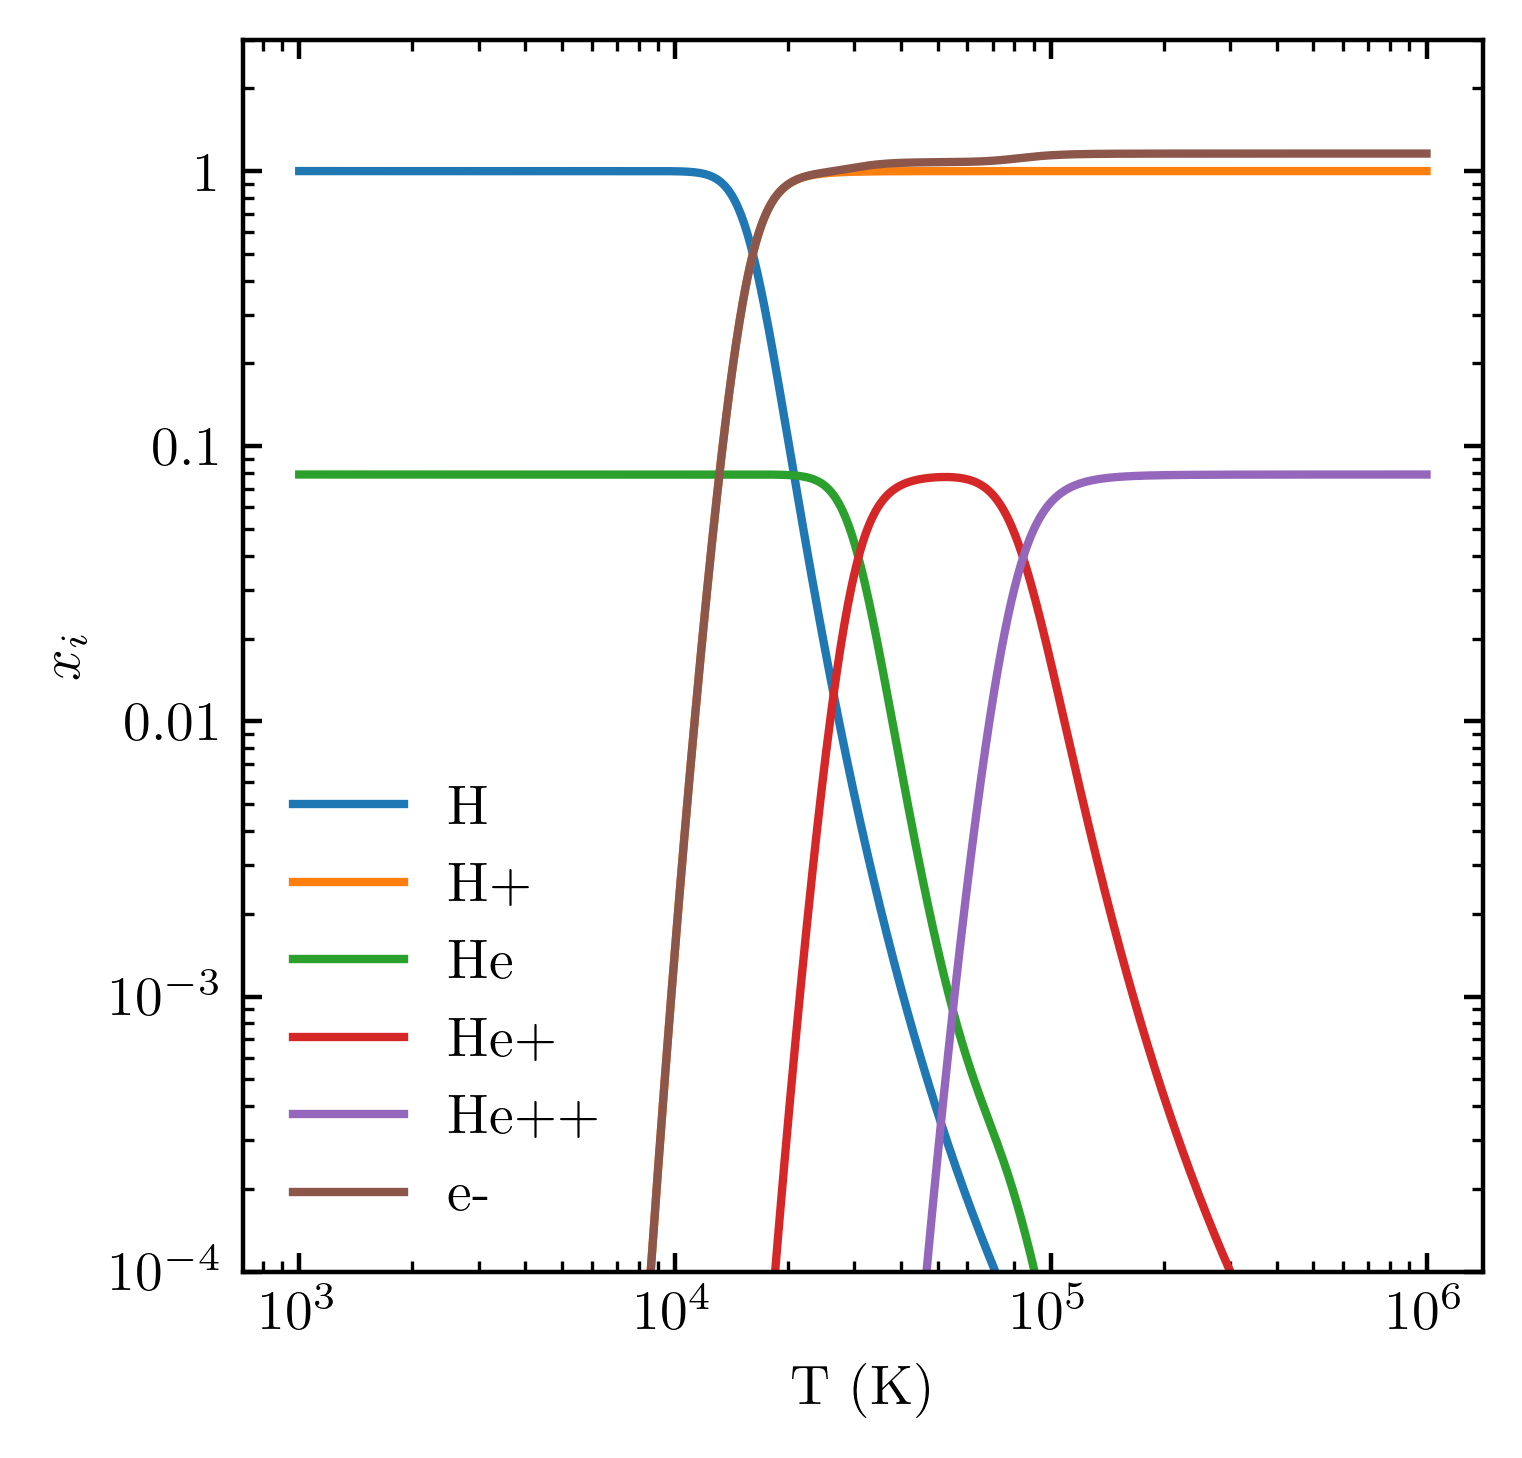

In [10]:
 #1e-6,1e-6,0.5) # n_H n_He n_He+ n_e- initial guess

func = sp.lambdify(unknowns+knowns, reduced_network) # what is going on in the backend here?
jacfunc =  sp.lambdify(unknowns + knowns, jac)


def solve_abundances(Tval, x0=None):
    knownvals = (Tval, 1, 0.24)

    def f_numerical(X):
        arg = tuple(X) + knownvals
        return func(*arg)

    def jac_numerical(X):
        arg = tuple(X) + knownvals
        return jacfunc(*arg)

    if x0 is None:
        x0 = np.array([0.5,1e-5, 1e-5])

    X = x0
    X_iter = []
    dx = 1e100 * x0
    tol = 1e-3
    n_iter = 0
#    while(np.any(np.abs(dx/X) > tol)):
    for _ in range(100):
        X_iter.append(np.copy(X))
        J = jac_numerical(X)
        f = f_numerical(X)
        dx = -np.linalg.solve(J, f) # don't actually have to invert!
        X += dx
        n_iter += 1

    return X

Tgrid = np.logspace(3,6,10**3)

sol = []

def run_solution():
    x0 = solve_abundances(Tgrid[0])
    for T in Tgrid:
        x0 = solve_abundances(T,x0=x0)
        sol.append(np.copy(x0))

t = time()
run_solution()
print(time() - t, sol)
sol = np.array(sol)


# need to abstract this process of substituting the conservation equations...
Y = 0.24
nHtot = 1
nHepp = Y/(4-4*Y)*nHtot - sol[:,1] - sol[:,2] 
sol = np.c_[sol, nHepp]
nHp = nHtot - sol[:,0]
ne = 2*nHepp + nHp + sol[:,2]
sol = np.c_[sol[:,0],nHp,sol[:,1],sol[:,2], nHepp, ne]


plt.loglog(Tgrid, sol, label=("H", "H+", "He", "He+", "He++", "e-"))#,label=unknowns)
plt.ylim(1e-4,3)
plt.ylabel(r"$x_i$")
#plt.ylabel(r"$n_i\,\left(\rm cm^{-3}\right)$")
plt.xlabel(r"T (K)")
plt.legend()

In [11]:
# import ChiantiPy.core as ch

# he = ch.ioneq(2)
# he.load()
# he.calculate(Tgrid)

# for i in range(3):
#     plt.loglog(Tgrid, he.Ioneq[i], ls='dashed',color='black',label=("CHIANTI" if i==0 else None))
#     plt.loglog(Tgrid, sol[:,2+i]/sol[:,2:5].sum(1), ls='solid',color='black',label=("pism" if i==0 else None))
# plt.ylim(1e-3,1.1)
# plt.legend()
# plt.xlabel(r"T (K)")
# plt.ylabel(r"Fraction")

# JAX implementation

[[ 9.9999994e-01  7.8947358e-02  9.4650289e-28]
 [ 9.9999994e-01  7.8947358e-02 -8.0482109e-29]
 [ 9.9999994e-01  7.8947358e-02 -2.3583325e-28]
 ...
 [ 1.0241124e-09  4.5322810e-15  1.1750668e-08]
 [ 1.0240887e-09  4.5320710e-15  1.1750404e-08]
 [ 1.0240651e-09  4.5318613e-15  1.1750138e-08]]
1.114905834197998
[[ 9.9999994e-01  7.8947358e-02 -2.7176460e-29]
 [ 9.9999994e-01  7.8947358e-02  8.5704672e-28]
 [ 9.9999994e-01  7.8947358e-02  1.0117582e-27]
 ...
 [ 8.9190033e-10  3.4477184e-15  1.0284862e-08]
 [ 8.9187968e-10  3.4475581e-15  1.0284629e-08]
 [ 8.9185859e-10  3.4473997e-15  1.0284399e-08]]
0.1555333137512207
{CudaDevice(id=0)}


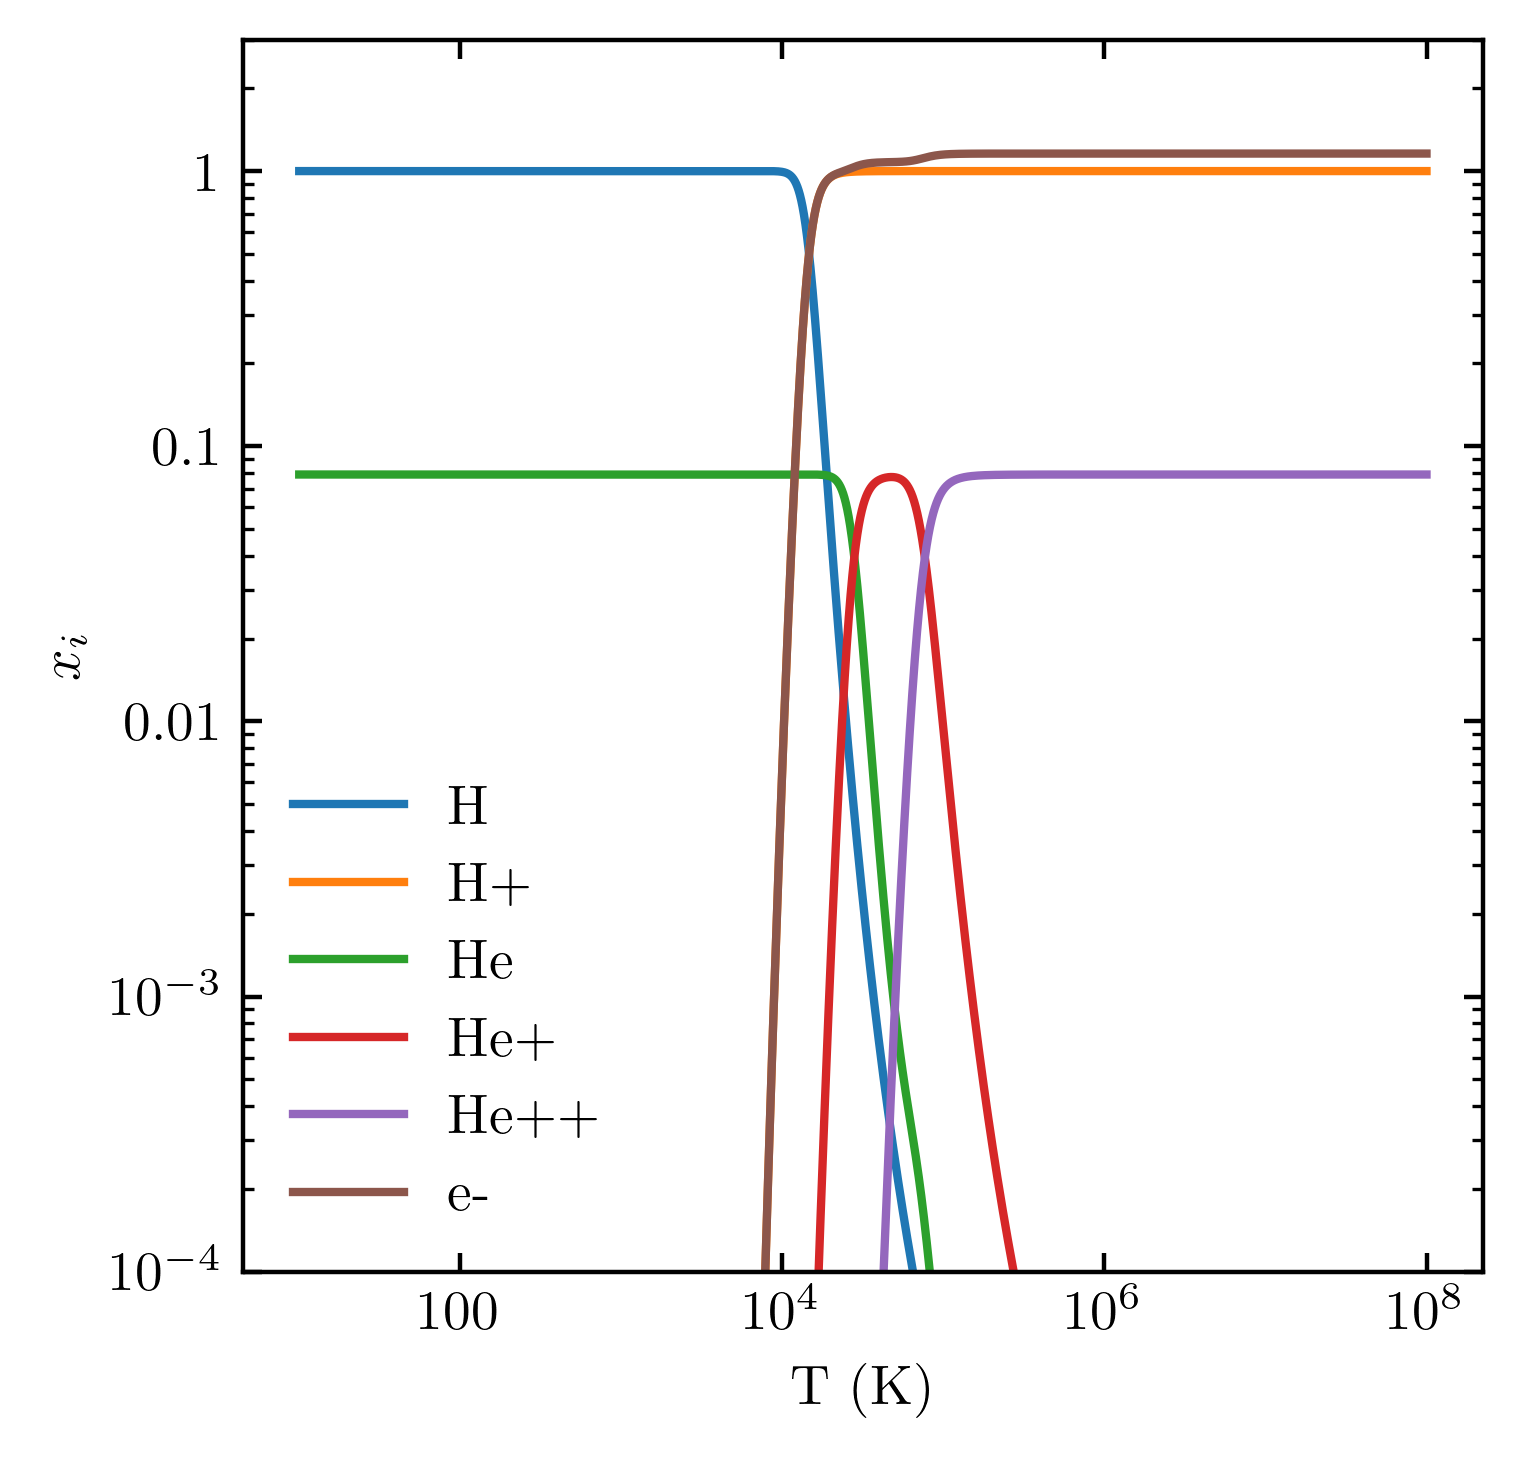

In [49]:
 #1e-6,1e-6,0.5) # n_H n_He n_He+ n_e- initial guess
import jax, jax.numpy as jnp
from jaxopt import ScipyRootFinding


func = sp.lambdify(unknowns+knowns, reduced_network,modules='jax')
jacfunc =  sp.lambdify(unknowns + knowns, jac,modules='jax') # do we need this or should we diff on the jax side?

@jax.jit
def solve_abundances(Tval, func=func, jacfunc=None, rtol=1e-2, atol=1e-100):

    # def f_numerical(X,knownvals):
    #     return jnp.array(func(*X, *knownvals))
    
    def f_numerical(X,knownvals):
        return jnp.array(func(*X, *knownvals))

    if jacfunc is None:
        jac_numerical = jax.jacfwd(f_numerical)
    else:
        def jac_numerical(X,knownvals):
            return jnp.array(jacfunc(*X, *knownvals))

    x0 = jnp.array([0.5,1e-5, 1e-5])

    # solver = ScipyRootFinding(optimality_fun=f_numerical)

    # def solve_for_T(T):
    #     knownvals = jnp.array([T, 1, 0.24])
    #     return solver.run(x0, *knownvals)[0]
    
    def solve_for_T(T):
        knownvals = jnp.array([T, 1, 0.24])

        def iter_condition(arg):
            X, dx = arg
            return jnp.any(jnp.abs(dx) > rtol * jnp.abs(X) + atol)

        def X_new(arg):
            X, _ = arg            
            dx = -jnp.linalg.solve(jac_numerical(X,knownvals),f_numerical(X,knownvals))
            return X + dx, dx # - jnp.linalg.solve(J,f)
        
        init_val = x0, 100*x0
        return jax.lax.while_loop(iter_condition, X_new, init_val)[0]

    X = jax.vmap(solve_for_T)(Tval)
    return X

Tgrid = np.logspace(1,8,10**6)
from time import time
t = time()
sol = solve_abundances(Tgrid)
print(sol)
print(time() - t)
t = time()
sol = solve_abundances(1.1*Tgrid)
print(sol)
print(time() - t)

print(sol.devices())

# need to abstract this process of substituting the conservation equations...
Y = 0.24
nHtot = 1
nHepp = Y/(4-4*Y)*nHtot - sol[:,1] - sol[:,2] 
sol = np.c_[sol, nHepp]
nHp = nHtot - sol[:,0]
ne = 2*nHepp + nHp + sol[:,2]
sol = np.c_[sol[:,0],nHp,sol[:,1],sol[:,2], nHepp, ne]


plt.loglog(Tgrid, sol, label=("H", "H+", "He", "He+", "He++", "e-")) #,label=unknowns)
plt.ylim(1e-4,3)
plt.ylabel(r"$x_i$")
#plt.ylabel(r"$n_i\,\left(\rm cm^{-3}\right)$")
plt.xlabel(r"T (K)")
plt.legend()

#%timeit solve_abundances(Tgrid)